In [ ]:
#| default_exp models.deepar

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# DeepAR


The DeepAR methodology produces probabilistic forecasts based on an autoregressive recurrent neural network optimized on panel data using cross-learning. DeepAR obtains its predictive distribution under Markov assumption compatible with many models for the following conditional probability:
$$\mathbb{P}(\mathbf{y}_{[t+1:t+H]}|\;\mathbf{y}_{[:t]},\; \mathbf{x}^{(h)}_{[:t]},\; \mathbf{x}^{(f)}_{[:t+H]},\; \mathbf{x}^{(s)})$$

where $\mathbf{x}^{(s)}$ are static exogenous inputs, $\mathbf{x}^{(h)}_{t}$ historic exogenous, $\mathbf{x}^{(f)}_{[:t+H]}$ are future exogenous available at the time of the prediction.
The predictions are obtained by transforming the hidden states $\mathbf{h}_{t}$ into predictive distribution parameters $\theta_{\tau}$, and then generating samples $\mathbf{\hat{y}}_{[t+1:t+H]}$ through a recurrent multi-step forecasting strategy (Monte Carlo).

\begin{align}
 \mathbf{h}_{t} &= \textrm{RNN}([\mathbf{y}_{t},\mathbf{x}^{(h)}_{t},\mathbf{x}^{(s)}], \mathbf{h}_{t-1})\\
\mathbf{\theta}_{\tau}&=\textrm{Linear}([\mathbf{h}_{\tau}, \mathbf{x}^{(f)}_{\tau}]) \\ 
\hat{y}_{\tau}&=\textrm{sample}(\;\mathrm{P}(y_{\tau}\;|\;\mathbf{\theta}_{\tau}(\hat{y}_{\tau}))\;)
\end{align}

**References**<br>
- [David Salinas, Valentin Flunkert, Jan Gasthaus, Tim Januschowski (2020). "DeepAR: Probabilistic forecasting with autoregressive recurrent networks". International Journal of Forecasting.](https://www.sciencedirect.com/science/article/pii/S0169207019301888)<br>
- [Alexander Alexandrov et. al (2020). "GluonTS: Probabilistic and Neural Time Series Modeling in Python". Journal of Machine Learning Research.](https://www.jmlr.org/papers/v21/19-820.html)<br>

In [ ]:
# Revisar
# 1. Distribution Outputs: https://github.com/awslabs/gluonts/blob/3145a81ecd751b410148c0230989e0459ce37716/src/gluonts/torch/distributions/distribution_output.py
# 2. DeepAR P module: https://github.com/awslabs/gluonts/blob/3145a81ecd751b410148c0230989e0459ce37716/src/gluonts/torch/model/deepar/module.py
# 3. DeepAR PL module: https://github.com/awslabs/gluonts/blob/3145a81ecd751b410148c0230989e0459ce37716/src/gluonts/torch/model/deepar/lightning_module.py#L25

# Revisar 2
# PL <- model.distribution_output <- PT.Distribution + NegativeLogLikelihood 

![Figure 1. DeepAR model, during training the optimization signal comes from likelihood of observations, during inference a recurrent multi-step strategy is used to generate predictive distributions.](imgs_models/deepar.png)

In [ ]:
#| export
from typing import List

import torch
import torch.nn as nn

from neuralforecast.losses.pytorch import MAE, MQLoss
from neuralforecast.common._base_recurrent import BaseRecurrent
from neuralforecast.common._modules import MLP, TemporalConvolutionEncoder

In [ ]:
#| hide
from nbdev.showdoc import show_doc

import logging
import warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [ ]:
#| exporti
class StaticCovariateEncoder(nn.Module):
    def __init__(self, in_features, out_features):
        super(StaticCovariateEncoder, self).__init__()
        layers = [nn.Dropout(p=0.5),
                  nn.Linear(in_features=in_features, 
                            out_features=out_features),
                  nn.ReLU()]
        self.encoder = nn.Sequential(*layers)

    def forward(self, x, repeats):        
        # Apply Static Encoder and repeat data.
        # [N,S_in] -> [N,S_out] -> [N,T,S_out]
        x = self.encoder(x)
        x = x.unsqueeze(1).repeat(1, repeats, 1)
        return x

In [ ]:
#| export
class DeepAR(BaseRecurrent):
    """ DeepAR1

    The DeepAR architecture produces predictive distributions based on
    an autoreggresive recurrent neural network, its outputs use a multi-step 
    recurrent forecasting strategy.

    **Parameters:**<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, maximum sequence length for truncated train backpropagation. Default -1 uses all history.<br>
    `stat_hidden_size`: int, dimension of the embedding space for each static feature.<br>
    `encoder_n_layers`: int=2, number of layers for the LSTM.<br>
    `encoder_hidden_size`: int=200, units for the LSTM's hidden state size.<br>
    `encoder_activation`: str=`tanh`, type of LSTM activation from `tanh` or `relu`.<br>
    `encoder_bias`: bool=True, whether or not to use biases b_ih, b_hh within LSTM units.<br>
    `encoder_dropout`: float=0., dropout regularization applied to LSTM outputs.<br>
    `context_size`: int=10, size of context vector for each timestamp on the forecasting window.<br>
    `decoder_hidden_size`: int=200, size of hidden layer for the MLP decoder.<br>
    `decoder_layers`: int=2, number of layers for the MLP decoder.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `learning_rate`: float=1e-3, initial optimization learning rate (0,1).<br>
    `batch_size`: int=32, number of differentseries in each batch.<br>
    `scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    
    """
    def __init__(self,
                 h: int,
                 input_size: int = -1,
                 stat_hidden_size: int = 10,
                 encoder_n_layers: int = 2,
                 encoder_hidden_size: int = 200,
                 encoder_bias: bool = True,
                 encoder_dropout: float = 0.,
                 context_size: int = 10,
                 decoder_hidden_size: int = 200,
                 decoder_layers: int = 2,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 loss = MQLoss(level=[80, 90]),
                 learning_rate: float = 1e-3,
                 batch_size=32,
                 scaler_type: str='robust',
                 random_seed=1,
                 num_workers_loader=0,
                 drop_last_loader=False,
                 **trainer_kwargs):
        super(DeepAR, self).__init__(
              h = h,
              input_size = input_size,
              loss=loss,
              learning_rate = learning_rate,
              batch_size=batch_size,
              scaler_type=scaler_type,
              futr_exog_list=futr_exog_list,
              hist_exog_list=hist_exog_list,
              stat_exog_list=stat_exog_list,
              num_workers_loader=num_workers_loader,
              drop_last_loader=drop_last_loader,
              random_seed=random_seed,
              **trainer_kwargs)
        #---------------------------------------- Parsing dimensions --------------------------------------#
        # Parsing input dimensions
        self.futr_exog_size = len(self.futr_exog_list)
        self.hist_exog_size = len(self.hist_exog_list)
        self.stat_exog_size = len(self.stat_exog_list)
        self.stat_hidden_size = stat_hidden_size if self.stat_exog_size>0 else 0

        # LSTM
        self.encoder_n_layers = encoder_n_layers
        self.encoder_hidden_size = encoder_hidden_size
        self.encoder_bias = encoder_bias
        self.encoder_dropout = encoder_dropout

        # Context adapter
        self.context_size = context_size

        # MLP decoder
        self.decoder_hidden_size = decoder_hidden_size
        self.decoder_layers = decoder_layers

        # LSTM input size (1 for target variable y)
        input_encoder = 1 + self.hist_exog_size + self.stat_hidden_size

        #-------------------------------------- Instantiate Components ------------------------------------#
        # Instantiate model components
        self.stat_encoder = StaticCovariateEncoder(
                                            in_features=self.stat_exog_size,
                                            out_features=stat_hidden_size)
#         self.hist_encoder = nn.LSTM(input_size=input_encoder,
#                                     hidden_size=self.encoder_hidden_size,
#                                     num_layers=self.encoder_n_layers,
#                                     bias=self.encoder_bias,
#                                     dropout=self.encoder_dropout,
#                                     batch_first=True)
        
        # Instantiate historic encoder
        self.hist_encoder = TemporalConvolutionEncoder(
                                   in_channels=input_encoder,
                                   out_channels=self.encoder_hidden_size,
                                   kernel_size=2, # Almost like lags
                                   dilations=[1,2,4,8,16],
                                   activation='ReLU')

        # Context adapter
        self.context_adapter = nn.Linear(in_features=self.encoder_hidden_size + self.futr_exog_size * h,
                                         out_features=self.context_size * h)

        # Decoder MLP
        self.mlp_decoder = MLP(in_features=self.context_size + self.futr_exog_size,
                               out_features=self.loss.outputsize_multiplier,
                               hidden_size=self.decoder_hidden_size,
                               num_layers=self.decoder_layers,
                               activation='ReLU',
                               dropout=0.0)

    def forward(self, windows_batch):

        # Parse windows_batch
        encoder_input = windows_batch['insample_y'] # [B, seq_len, 1]
        futr_exog     = windows_batch['futr_exog']
        hist_exog     = windows_batch['hist_exog']
        stat_exog     = windows_batch['stat_exog']

        # Concatenate y, historic and static inputs
        # [B, C, seq_len, 1] -> [B, seq_len, C]
        # Contatenate [ Y_t, | X_{t-L},..., X_{t} | S ]
        batch_size, seq_len = encoder_input.shape[:2]
        if self.hist_exog_size > 0:
            hist_exog = hist_exog.permute(0,2,1,3).squeeze(-1) # [B, X, seq_len, 1] -> [B, seq_len, X]
            encoder_input = torch.cat((encoder_input, hist_exog), dim=2)

        if self.stat_exog_size > 0:
            stat_hidden = self.stat_encoder(x=stat_exog, repeats=seq_len)  # [B, seq_len, S_out]
            encoder_input = torch.cat((encoder_input, stat_hidden), dim=2)

        # RNN forward
        #hidden_state, _ = self.hist_encoder(encoder_input) # [B, seq_len, rnn_hidden_state]
        hidden_state = self.hist_encoder(encoder_input) # [B, seq_len, rnn_hidden_state]

        if self.futr_exog_size > 0:
            futr_exog = futr_exog.permute(0,2,3,1)[:,:,1:,:]  # [B, F, seq_len, 1+H] -> [B, seq_len, H, F]
            hidden_state = torch.cat(( hidden_state, futr_exog.reshape(batch_size, seq_len, -1)), dim=2)

        # Context adapter
        context = self.context_adapter(hidden_state)
        context = context.reshape(batch_size, seq_len, self.h, self.context_size)

        # Residual connection with futr_exog
        if self.futr_exog_size > 0:
            context = torch.cat((context, futr_exog), dim=-1)

        # Final forecast
        output = self.mlp_decoder(context)
        output = self.loss.domain_map(output)

        return output

In [ ]:
show_doc(DeepAR)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/deepar.py#L34){target="_blank" style="float:right; font-size:smaller"}

### DeepAR

>      DeepAR (h:int, input_size:int=-1, stat_hidden_size:int=10,
>              encoder_n_layers:int=2, encoder_hidden_size:int=200,
>              encoder_bias:bool=True, encoder_dropout:float=0.0,
>              context_size:int=10, decoder_hidden_size:int=200,
>              decoder_layers:int=2, futr_exog_list=None, hist_exog_list=None,
>              stat_exog_list=None, loss=MQLoss(), learning_rate:float=0.001,
>              batch_size=32, scaler_type:str='robust', random_seed=1,
>              num_workers_loader=0, drop_last_loader=False, **trainer_kwargs)

DeepAR1

The DeepAR architecture produces predictive distributions based on
an autoreggresive recurrent neural network, its outputs use a multi-step 
recurrent forecasting strategy.

**Parameters:**<br>
`h`: int, forecast horizon.<br>
`input_size`: int, maximum sequence length for truncated train backpropagation. Default -1 uses all history.<br>
`stat_hidden_size`: int, dimension of the embedding space for each static feature.<br>
`encoder_n_layers`: int=2, number of layers for the LSTM.<br>
`encoder_hidden_size`: int=200, units for the LSTM's hidden state size.<br>
`encoder_activation`: str=`tanh`, type of LSTM activation from `tanh` or `relu`.<br>
`encoder_bias`: bool=True, whether or not to use biases b_ih, b_hh within LSTM units.<br>
`encoder_dropout`: float=0., dropout regularization applied to LSTM outputs.<br>
`context_size`: int=10, size of context vector for each timestamp on the forecasting window.<br>
`decoder_hidden_size`: int=200, size of hidden layer for the MLP decoder.<br>
`decoder_layers`: int=2, number of layers for the MLP decoder.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`learning_rate`: float=1e-3, initial optimization learning rate (0,1).<br>
`batch_size`: int=32, number of differentseries in each batch.<br>
`scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

In [ ]:
show_doc(DeepAR.fit, name='DeepAR.fit')

---

### DeepAR.fit

>      DeepAR.fit (dataset, val_size=0, test_size=0)

Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `batch_size`, ...)
and the `loss` function as defined during the initialization. 
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect 
disk memory, to get them change `enable_checkpointing=True` in `__init__`.        

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`test_size`: int, test size for temporal cross-validation.<br>

In [ ]:
show_doc(DeepAR.predict, name='DeepAR.predict')

---

### DeepAR.predict

>      DeepAR.predict (dataset, step_size=1, **data_module_kwargs)

Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`step_size`: int=1, Step size between each window.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).

## Usage Example

In [ ]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss, wMQLoss, PMM, DistributionLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic

from neuralforecast.losses.pytorch import MAE, SMAPE, QuantileLoss

AirPassengersPanel = AirPassengersPanel[AirPassengersPanel.unique_id=='Airline1']
#AirPassengersPanel['y'] = (AirPassengersPanel['y'] - np.mean(AirPassengersPanel['y'])) / np.std(AirPassengersPanel['y'])
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

fcst = NeuralForecast(
    models=[DeepAR(h=12,
                   input_size=-1,
                   stat_hidden_size=2,
                   #encoder_n_layers=2,
                   encoder_hidden_size=128,
                   context_size=10,
                   decoder_hidden_size=128,
                   decoder_layers=1,
                   #loss=MAE(),
                   #loss=SMAPE(),
                   #loss=QuantileLoss(q=0.5),
                   #loss=MQLoss(level=[80, 90]),
                   #loss=PMM(n_lambdas=10, level=[80, 90]),
                   loss=DistributionLoss(level=[80, 90]),
                   #loss=wMQLoss(level=[80, 90]),
                   #loss=StudentTLoss(level=[80, 90]),
                   max_epochs=500,
                   learning_rate=1e-3,
                   scaler_type=None,
                   futr_exog_list=['y_[lag12]'])
    ],
    freq='M'
)
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic)
forecasts = fcst.predict(futr_df=Y_test_df)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[]

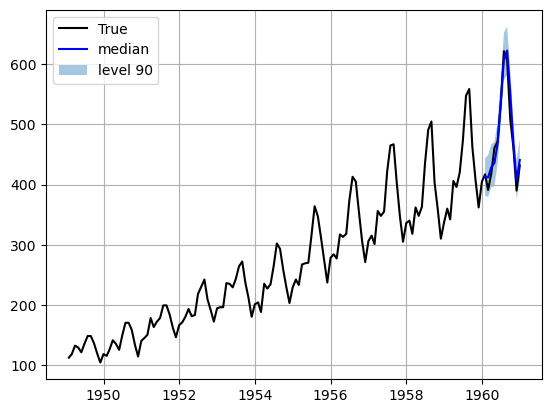

In [ ]:
#| eval: false
# Plot
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
try:
    plt.plot(plot_df['ds'], plot_df['DeepAR-median'], c='blue', label='median')
    plt.fill_between(x=plot_df['ds'], 
                     y1=plot_df['DeepAR-lo-90.0'], y2=plot_df['DeepAR-hi-90.0'],
                     alpha=0.4, label='level 90')
except:
    plt.plot(plot_df['ds'], plot_df['DeepAR'], c='blue', label='median')
plt.grid()
plt.legend()
plt.plot()